### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

переобозначим $$a(x{i}) = z$$
1) MSE: 
Тогда $$ -\frac{\partial }{\partial z}(y_i-z)^2 = 2(y_i - z)$$
2)Экспоненциальная:
    $$ -\frac{\partial }{\partial z}(exp(-z y_i) = y_i exp(-z y_i), y_i \in \{-1, 1\} $$
3)Логистическая:
    $$ - \frac{\partial }{\partial z} \log (1 + exp( -z y_i)) = \frac{y_i exp(-z y_i)}{1+exp(-z y_i)}, y_i \in \{-1, 1\}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [23]:
class MyGradientBoostingClassifier:

    def __init__(self, loss, learning_rate, n_estimators, colsample, subsample, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        if loss == 'MSE':
            self.__get_loss = self.__get_MSE
            self.__get_grad = self.__get_MSE_grad
        elif loss == 'exp':
            self.__get_loss = self.__get_exp
            self.__get_grad = self.__get_exp_grad
        elif loss == 'log':
            self.__get_loss = self.__get_log
            self.__get_grad = self.__get_log_grad
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        
    def __get_MSE(self, real, preds):
        return (real - preds) ** 2

    def __get_exp(self, real, preds):
        return np.exp(-preds * real)

    def __get_log(self, real, preds):
        return np.log(1 + np.exp(-preds * real))

    def __get_MSE_grad(self, real, preds):
        return 2 * (real - preds)

    def __get_exp_grad(self, real, preds):
        return real * np.exp(-preds * real)

    def __get_log_grad(self, real, preds):
        return real * np.exp(-preds * real) / (1 + np.exp(-preds * real))

    
    def __init_model(self, init_model):
        if init_model is not None:
            self.init_model = init_model(*self.args, **self.kwargs)
            self.init_model.fit(self.X, self.y)
            self.ensemble  = np.float64(self.init_model.predict(self.X))
        else:
            self.ensemble  = np.float64(np.ones(self.y.shape[0]) / self.y.shape[0])
            self.init_model = None
        
        
    def __choose_data(self):
        features_inds = np.random.randint(
            0, self.X.shape[1], size=int(self.X.shape[1] * self.colsample))
        self.features_inds.append(features_inds)
        objects_inds = np.random.randint(
            0, self.X.shape[0], size=int(self.X.shape[0] * self.subsample))
        X_for_fit = self.X[np.ix_(objects_inds, features_inds)]
        X_pred = self.X[:, features_inds]
        y_for_fit = self.y[objects_inds]
        prev_res = self.ensemble[objects_inds]
        return X_for_fit, X_pred, y_for_fit, prev_res
    
    
    def fit(self, X, y, base_model, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.X = X
        self.y = y
        
        self.__init_model(init_model)

        self.models = []
        self.features_inds = []
        
        for t in range(self.n_estimators):
            X_for_fit, X_pred, y_for_fit, prev_res = self.__choose_data()
            target = self.__get_grad(y_for_fit, prev_res)
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_for_fit, target)
            self.models.append(model)
            self.ensemble += self.learning_rate * model.predict(X_pred)
                
        
    def predict(self, X):
        if self.init_model is None:
            preds = np.float64(np.ones(X.shape[0]) / X.shape[0])
        else:
            preds = np.float64(self.init_model.predict(X))
        for model, feat in zip(self.models, self.features_inds):
            preds += self.learning_rate * model.predict(X[:, feat])
        return np.around(preds)
       



In [26]:
my_clf = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=0.1, n_estimators = 100, colsample = 0.66, subsample =0.66)
clf = GradientBoostingClassifier()

In [27]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [28]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [15]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [16]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [47]:
kf = KFold(n_splits=5, shuffle=False)
full_res = []
estimators = np.arange(20, 161, 20)
for n in estimators:
    res = []
    for train_index, val_index in kf.split(X):
        model = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=0.1,n_estimators=n, colsample = 0.66, subsample =0.66)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, DecisionTreeRegressor)
        res.append(accuracy_score(y_val, model.predict(X_val)))
    print(n,':',np.mean(res))
    full_res.append(np.mean(res))

20 : 0.7603197674418605
40 : 0.7667635658914729
60 : 0.7732073643410853
80 : 0.7868217054263565
100 : 0.7616763565891473
120 : 0.769282945736434
140 : 0.7799418604651163
160 : 0.7725290697674418


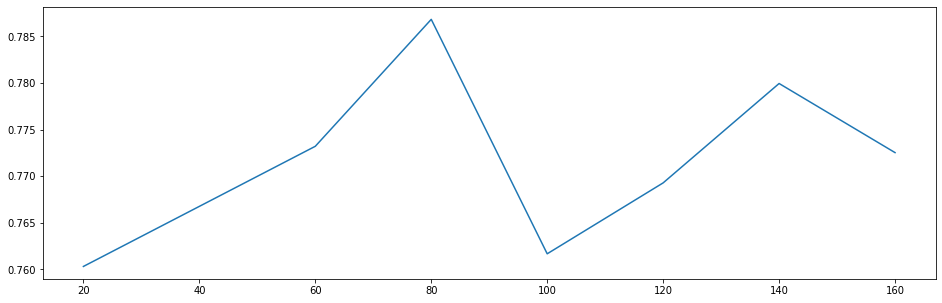

In [49]:
fig = plt.figure(figsize=(16, 5))
plt.plot(estimators, full_res)
plt.show()

In [50]:
best_n_estimators = 80

In [54]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for loss in ['MSE', 'exp', 'log']:
    res = []
    for train_index, val_index in kf.split(X):
        model = MyGradientBoostingClassifier(
            loss=loss, n_estimators=best_n_estimators,learning_rate=0.1, colsample = 0.66, subsample =0.66)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, DecisionTreeRegressor)
        res.append(accuracy_score(y_val, model.predict(X_val)))
    mean = np.mean(res)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_loss = loss

0.7781976744186047


In [55]:
best_loss

'MSE'

In [58]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for learning_rate_ in [0.05, 0.1, 0.3, 0.5]:
    res = []
    for train_index, val_index in kf.split(X):
        model = MyGradientBoostingClassifier(
            loss='MSE', n_estimators=best_n_estimators,learning_rate=learning_rate_, colsample = 0.66, subsample =0.66)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, DecisionTreeRegressor)
        res.append(accuracy_score(y_val, model.predict(X_val)))
    mean = np.mean(res)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_lr = learning_rate_

0.797577519379845


In [59]:
best_lr

0.05

In [61]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for colsample in [1.0, 0.66, 0.5, 0.2]:
    res = []
    for train_index, val_index in kf.split(X):
        model = MyGradientBoostingClassifier(
            loss=best_loss, n_estimators=best_n_estimators, learning_rate=best_lr, colsample=colsample, subsample = 0.66)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res.append(accuracy_score(y_val, model.predict(X_val)))
    mean = np.mean(res)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_colsample = colsample

0.817296511627907


In [62]:
best_colsample

1.0

In [63]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for subsample in [1.0, 0.66, 0.5, 0.2]:
    res = []
    for train_index, val_index in kf.split(X):
        model = MyGradientBoostingClassifier(
            loss=best_loss, n_estimators=best_n_estimators, learning_rate=best_lr, colsample=best_colsample, subsample = subsample)
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        res.append(accuracy_score(y_val, model.predict(X_val)))
    mean = np.mean(res)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_subsample = subsample

0.8142441860465116
0.8188953488372093
0.8194767441860465


In [66]:
best_subsample

0.5

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
model = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=best_lr,n_estimators=best_n_estimators, colsample = best_colsample, subsample =best_subsample)
model.fit(X_train,y_train,DecisionTreeRegressor)
accuracy_score(y_test, model.predict(X_test))

0.8834409864944216

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [8]:
model = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=0.05,n_estimators=80, colsample = 1.0, subsample =0.5)
model.fit(X_train,y_train,RandomForestRegressor)
accuracy_score(y_test, model.predict(X_test))

0.8932765707574868

In [18]:
def process_random_boost(i):
    model = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=0.05,n_estimators=80, colsample = 1.0, subsample =0.5)
    samples_inds = np.random.randint(0, X_train.shape[0], size=int(X_train.shape[0] / N))
    X_boost = X_train[samples_inds, :]
    y_boost = y_train[samples_inds]
    model.fit(X_boost, y_boost, DecisionTreeRegressor)
    preds = model.predict(X_test)
    with lock:
        boots_res.append(preds)
        pbar.update(1)

In [39]:
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm

In [40]:
N = 70
with Pool(10) as pool, tqdm(N) as pbar:
    boots_res = []
    lock = pbar.get_lock()
    pool.map(process_random_boost, range(N))
pool.join()
print(accuracy_score(y_test, np.sum(boots_res, axis=0) / N > 0.5))

70it [00:04, 14.86it/s]

0.8556958308866706


в первом случае удалось поднять скор, как мне кажется из-за того что RandomForest в принципе выдает точность больше чем решающие деревья, а соответственно быстрее сходится на бустинге, но тут главное не переобучиться, вероятней всего даже мои параметры в первом случае находятся не на самом подходящем пике, я пробовал их подобрать, но загрузка была бесконечная просто.
Во втором случае скор упал немного.По сути мы сделали N бустингов и усреднили их, звучит вроде как неплохо, думаю при подходящих параметрах, он не сильно будет уступать.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [41]:
model = MyGradientBoostingClassifier(loss = 'MSE', learning_rate=0.05,n_estimators=80, colsample = 1.0, subsample =0.5)

In [42]:
model.fit(X_train, y_train, DecisionTreeRegressor,init_model=SGDClassifier)
accuracy_score(y_test, model.predict(X_test))

0.8310334703464475

In [43]:
model.fit(X_train, y_train, DecisionTreeRegressor,init_model=SVC)
accuracy_score(y_test, model.predict(X_test))

0.8787433940105696

In [44]:
model.fit(X_train, y_train, DecisionTreeRegressor,init_model=RandomForestRegressor)
accuracy_score(y_test, model.predict(X_test))

0.8805049911920141

Ну тут явно побеждает randomforest, так как он изначально уже выдает хорошее направление

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
Все супер!Было бы круто, если бы в курсе появились конспекты лекций в pdf формате, в каком-то более развернутом виде. 